In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0


In [40]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

%load_ext nvcc_plugin

  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-4xx9xhk0
  Running command git clone -q https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-4xx9xhk0
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4306 sha256=77782f09783a8988879cb4b88a967e7ea31fa0ddf4c63489d81f215036bfd9f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_99pp89/wheels/ca/33/8d/3c86eb85e97d2b6169d95c6e8f2c297fdec60db6e84cb56f5e
Successfully built NVCCPlugin
created output directory at /content/src
Out bin /content/result.out


**Laplace equation** (chose the 1st approach: inverse the matrix)
____

In [28]:
%%cu
#include <cmath>
#include <iostream>
#include <fstream>

const size_t N/*vertical segments number*/= 6, M/*horizontal segments number*/= 6;
const double x_left = 0, x_right = 1;  // edges
const double y_left = 0, y_right = 1;  // edges


// boundary conditions
const double x_left_bound = 0,  x_right_bound = 0;
const double y_left_bound = 1,  y_right_bound = 0;

// uniform steps
const double x_step = (x_right - x_left) / M;
const double y_step = (y_right - y_left) / N;


const size_t rows = N - 1, cols = M - 1;

void FillSystem(double *A, double *b) {
    for (int i = 0; i < cols; ++i) {
        for (int j = 0; j < rows; ++j) {
            A[(i*rows+j)*(rows*cols)+i*rows+j] = -2 * (x_step*x_step + y_step*y_step);
            if (i == 0) b[i*rows + j] -= y_step*y_step * x_left_bound;
            else A[(i*rows+j)*(rows*cols)+(i-1)*rows+j] = y_step*y_step;
            if (i == cols-1) b[i*rows + j] -= y_step*y_step * x_right_bound;
            else A[(i*rows+j)*(rows*cols)+(i+1)*rows+j] = y_step*y_step;
            if (j == 0) b[i*rows + j] -= x_step*x_step * y_left_bound;
            else A[(i*rows+j)*(rows*cols)+i*rows+j-1] = x_step*x_step;
            if (j == rows-1) b[i*rows + j] -= x_step*x_step * y_right_bound;
            else A[(i*rows+j)*(rows*cols)+i*rows+j+1] = x_step*x_step;
        }
    }
}

double * CreateField(double* x) {
    double * u = new double[(N+1)*(M+1)]();
    for (size_t i = 0; i <= N; ++i)
        u[i*(M+1)] = x_left_bound, u[i*(M+1) + M] = x_right_bound;
    for (size_t i = 0; i <= M; ++i)
        u[i] = y_left_bound, u[(N+1)*M + i] = y_right_bound;
    for (size_t i = 0; i < cols; ++i)
      for (size_t j = 0; j < rows; ++j)
          u[(j+1)*(M+1)+i+1] = x[i*rows + j];
    return u;
}

void PrintField(double* u) {
    for (int i = N; i >= 0; --i) {
        for (int j = 0; j < M+1; ++j) {
            std::cout << u[i*(M+1) +j] << " ";
        }
        std::cout << std::endl;
    }
}

void SaveToFile(double* u) {
    std::ofstream f("field.txt");
    for (int i = N; i >= 0; --i) {
        for (int j = 0; j < M+1; ++j) {
            f << u[i*(M+1) +j] << " ";
        }
        f << std::endl;
    }
    std::cout << "Field's been saved to './field.txt'" << std::endl;
}

// CUDA
__device__ int max_element_index;

__global__ void MaxInColumn(double* matrix, int n, int x) {
  int max_index = x;
  double max_value = std::fabs(matrix[x * n + x]);
  double current_value;

  for (int i = x + 1; i < n; i++) {
    current_value = std::fabs(matrix[i * n + x]);
    if (current_value > max_value) {
      max_index = i;
      max_value = current_value;
    }
  }

  max_element_index = max_index;
}

__global__ void SwapLines(double* matrix, double* identity, int n, int row) {
  if (row == max_element_index) {
    return;
  }

  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int offset = gridDim.x * blockDim.x;

  double temp;
  for (; idx < n; idx += offset) {
    temp = matrix[row * n + idx];
    matrix[row * n + idx] = matrix[max_element_index * n + idx];
    matrix[max_element_index * n + idx] = temp;

    temp = identity[row * n + idx];
    identity[row * n + idx] = identity[max_element_index * n + idx];
    identity[max_element_index * n + idx] = temp;
  }
}

__global__ void SubtractBelow(double* matrix, double* identity, int n, int x) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int idy = blockIdx.y * blockDim.y + threadIdx.y;
  int offsetx = gridDim.x * blockDim.x;
  int offsety = gridDim.y * blockDim.y;

  int i, j;
  double coeff;
  for (i = x + 1 + idx; i < n; i += offsetx) {
    coeff = matrix[i * n + x] / matrix[x * n + x];
    for (j = x + 1 + idy; j < n; j += offsety) {
      matrix[i * n + j] -= coeff * matrix[x * n + j];
    }
    for (j = idy; j < n; j += offsety) {
      identity[i * n + j] -= coeff * identity[x * n + j];
    }
  }
}

__global__ void NullifyBelow(double* matrix, int n, int x) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int offsetx = gridDim.x * blockDim.x;
  for (int i = x + 1 + idx; i < n; i += offsetx) {
    matrix[i * n + x] = 0.0;
  }
}

__global__ void SubtractAbove(double* matrix, double* identity, int n, int x) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int idy = blockIdx.y * blockDim.y + threadIdx.y;
  int offsetx = gridDim.x * blockDim.x;
  int offsety = gridDim.y * blockDim.y;

  int i, j;
  double coeff;
  for (i = x - 1 - idx; i >= 0; i -= offsetx) {
    coeff = matrix[i * n + x] / matrix[x * n + x];
    for (j = x - 1 - idy; j >= 0; j -= offsety) {
      matrix[i * n + j] -= coeff * matrix[x * n + j];
    }
    for (j = idy; j < n; j += offsety) {
      identity[i * n + j] -= coeff * identity[x * n + j];
    }
  }
}

__global__ void NullifyAbove(double* matrix, int n, int x) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int offsetx = gridDim.x * blockDim.x;
  for (int i = x - idx - 1; i >= 0; i -= offsetx) {
    matrix[i * n + x] = 0.0;
  }
}

__global__ void DevideIdentity(double* matrix, double* identity, int n) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int idy = blockIdx.y * blockDim.y + threadIdx.y;
  int offsetx = gridDim.x * blockDim.x;
  int offsety = gridDim.y * blockDim.y;

  for (int i = idx; i < n; i += offsetx) {
    for (int j = idy; j < n; j += offsety) {
      identity[i * n + j] /= matrix[i * n + i];
    }
  }
}

__global__ void DevideMatrix(double* matrix, int n) {
  int idx = blockIdx.x * blockDim.x + threadIdx.x;
  int offsetx = gridDim.x * blockDim.x;
  for (int i = idx; i < n; i += offsetx) {
    matrix[i * n + i] = 1.0;
  }
}

void InverseGPU(double* matrix, double* identity, int n) {
  dim3 BLOCKS_1D(8);
  dim3 THREADS_1D(32);
  dim3 BLOCKS_2D(8, 8);
  dim3 THREADS_2D(32, 32);

  double* dev_matrix;
  double* dev_identity;
  cudaMalloc(&dev_matrix, sizeof(double) * n * n);
  cudaMalloc(&dev_identity, sizeof(double) * n * n);
  cudaMemcpy(dev_matrix, matrix, sizeof(double) * n * n,
             cudaMemcpyHostToDevice);
  cudaMemcpy(dev_identity, identity, sizeof(double) * n * n,
             cudaMemcpyHostToDevice);

  cudaEvent_t start, stop;

  cudaEventCreate(&start);
  cudaEventCreate(&stop);
  cudaEventRecord(start, 0);

  // forward pass
  for (int i = 0; i < n; i++) {
    MaxInColumn<<<1, 1>>>(dev_matrix, n, i);
    SwapLines<<<BLOCKS_1D, THREADS_1D>>>(dev_matrix, dev_identity, n, i);
    SubtractBelow<<<BLOCKS_2D, THREADS_2D>>>(dev_matrix, dev_identity, n, i);
    NullifyBelow<<<BLOCKS_1D, THREADS_1D>>>(dev_matrix, n, i);
  }

  // backward pass
  for (int i = n - 1; i >= 0; i--) {
    SubtractAbove<<<BLOCKS_2D, THREADS_2D>>>(dev_matrix, dev_identity, n, i);
    NullifyAbove<<<BLOCKS_1D, THREADS_1D>>>(dev_matrix, n, i);
  }

  DevideIdentity<<<BLOCKS_2D, THREADS_2D>>>(dev_matrix, dev_identity, n);
  DevideMatrix<<<BLOCKS_1D, THREADS_1D>>>(dev_matrix, n);

  cudaEventRecord(stop, 0);
  cudaEventSynchronize(stop);
  float t;
  cudaEventElapsedTime(&t, start, stop);
  std::cout <<"Matrix invertion time: " << t << std::endl;
  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  cudaMemcpy(matrix, dev_matrix, sizeof(double) * n * n,
             cudaMemcpyDeviceToHost);
  cudaMemcpy(identity, dev_identity, sizeof(double) * n * n,
             cudaMemcpyDeviceToHost);
  cudaFree(dev_matrix);
  cudaFree(dev_identity);
}

__global__ void MatrixVectorMult(double *matrix, double *vector, double *result, int n) {
    int row = threadIdx.x + blockDim.x * blockIdx.x;
    double sum = 0;
   
    if(row < n)
      for(int j = 0;j < n; j++) {
        sum += matrix[row * n + j] * vector[j];
    }
    
    result[row] = sum;
}

void MatrixVectorMultGPU(double* matrix, double* vector, double* result, int n) {
  int THREADS = std::min(n, 512);
  int BLOCKS = std::ceil((1.0 * n) / THREADS);
  dim3 BLOCKS_2D(BLOCKS, BLOCKS);
  dim3 THREADS_2D(THREADS, THREADS);
  double *dev_matrix, *dev_vector, *dev_result;
  cudaMalloc(&dev_matrix, sizeof(double) * n * n);
  cudaMalloc(&dev_vector, sizeof(double) * n);
  cudaMalloc(&dev_result, sizeof(double) * n);
  cudaMemcpy(dev_matrix, matrix, sizeof(double) * n * n, cudaMemcpyHostToDevice);
  cudaMemcpy(dev_vector, vector, sizeof(double) * n, cudaMemcpyHostToDevice);

  cudaEvent_t start, stop;

  cudaEventCreate(&start);
  cudaEventCreate(&stop);
  cudaEventRecord(start, 0);

  MatrixVectorMult<<<BLOCKS_2D, THREADS_2D>>>(dev_matrix, dev_vector, dev_result, n);

  cudaEventRecord(stop, 0);
  cudaEventSynchronize(stop);
  float t;
  cudaEventElapsedTime(&t, start, stop);
  std::cout <<"Matrix-vector multiplication time: " << t << std::endl;
  cudaEventDestroy(start);
  cudaEventDestroy(stop);

  cudaMemcpy(result, dev_result, sizeof(double) * n, cudaMemcpyDeviceToHost);
  cudaFree(dev_matrix);
  cudaFree(dev_vector);
  cudaFree(dev_result);
}

int main() {
    double * A = new double[rows*cols*rows*cols]();
    double * x = new double[rows*cols]();
    double * b = new double[rows*cols]();
    
    FillSystem(A, b);

    double* I = new double[rows*cols*rows*cols]();  // identity matrix
    for (int i = 0; i < rows*cols; i++) I[i * rows*cols + i] = 1.0;


    InverseGPU(A, I, rows*cols); // I = A ^ (-1)

    MatrixVectorMultGPU(I, b, x, rows*cols);


    double * u = CreateField(x);
    PrintField(u);

    SaveToFile(u);

    delete[] A;
    delete[] b;
    delete[] x;
    delete[] u;
    delete[] I;

    return 0;
}

Matrix invertion time: 1.40614
Matrix-vector multiplication time: 0.034112
0 0 0 0 0 0 0 
0 0.0313131 0.0534674 0.0613442 0.0534674 0.0313131 0 
0 0.0717852 0.121212 0.138442 0.121212 0.0717852 0 
0 0.134615 0.221154 0.25 0.221154 0.134615 0 
0 0.245523 0.378788 0.41925 0.378788 0.245523 0 
0 0.468687 0.629225 0.669425 0.629225 0.468687 0 
1 1 1 1 1 1 1 
Field's been saved to './field.txt'



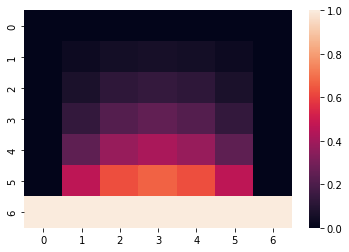

In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


with open('field.txt', 'r') as f:
  lines = [i.strip() for i in f.readlines()]
  field = [[float(j) for j in i.split()] for i in lines]

ax = sns.heatmap(field, linewidth=0.0)
plt.show()

**Filtering**
___

task says apply... so I did (:

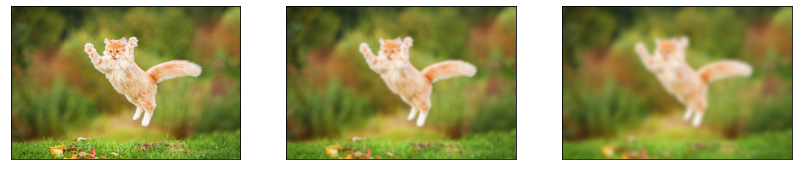

In [30]:
# Blurring filter
import math
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.modules.utils import _pair, _quadruple

from torchvision.io import read_image
import torchvision.transforms as T

torch.manual_seed(1)

def show(imgs):
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(14,14))
    for i, img in enumerate(imgs):
        img = T.ToPILImage()(img.to('cpu'))
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


cat = read_image('medn_7.jpg')
device = 'cuda'
cat_gpu = cat.clone().to(device)

blurred_cat_1 = T.GaussianBlur(kernel_size=(21,21), sigma=(7,7))(cat_gpu)
blurred_cat_2 = T.GaussianBlur(kernel_size=(53,53), sigma=(13,13))(cat_gpu)
show([cat, blurred_cat_1, blurred_cat_2])

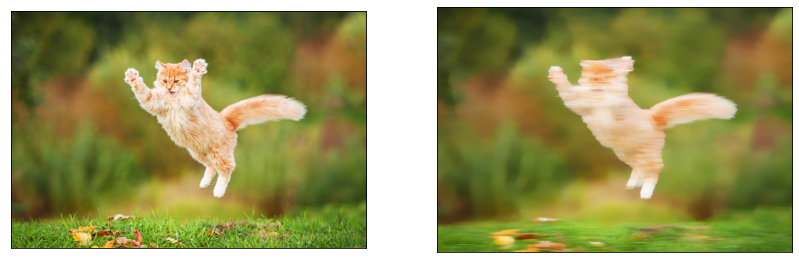

In [61]:
# Median filter
class MedianFilter(nn.Module):
    def __init__(self, kernel_size=57, padding=0):
        super(MedianFilter, self).__init__()
        self.k = _pair(kernel_size)
        self.stride = _pair(1)
        self.padding = _quadruple(padding)
    
    def forward(self, x):
        x = F.pad(x, self.padding)
        x = x.unfold(2, self.k[0], self.stride[0]).unfold(3, self.k[1], self.stride[1])
        x = x.contiguous().view(x.size()[:4] + (-1,)).median(dim=-1)[0]
        return x

cartoon_cat = MedianFilter()(cat_gpu)
show([cat, cartoon_cat.squeeze()])

**Histogram**
___

In [41]:
%%writefile histogram.cu
#include <fstream>
#include <iostream>
#include <opencv2/opencv.hpp>

using namespace cv;

__global__ void histogramGPU(unsigned char *img, int *histogram, int w, int h){
    unsigned int col = blockIdx.x*blockDim.x + threadIdx.x;
    unsigned int row = blockIdx.y*blockDim.y + threadIdx.y;


    if(col >= w || row >= h) return;
    atomicAdd(&(histogram[img[row*w + col]]), 1);
}


int main() {
    Mat img = imread("medn_7.jpg", CV_LOAD_IMAGE_GRAYSCALE);
    int host_hist[256] = {0};
    unsigned char* host_img = img.data;

    int h = img.rows;
    int w = img.cols;

    unsigned char* dev_img;
    int *dev_hist;

    cudaMalloc(&dev_img, sizeof(unsigned char) * h * w);
    cudaMalloc(&dev_hist, sizeof(int) * 256);
    

    cudaMemcpy(dev_img, host_img, sizeof(unsigned char) * h * w, cudaMemcpyHostToDevice);
    cudaMemcpy(dev_hist, host_hist, sizeof(int) * 256, cudaMemcpyHostToDevice);

    const int BLOCK_SIZE = 32;
    dim3 DimGrid((w + BLOCK_SIZE - 1) / BLOCK_SIZE, (h + BLOCK_SIZE - 1) / BLOCK_SIZE);
    dim3 DimBlock(BLOCK_SIZE, BLOCK_SIZE);



    histogramGPU<<<DimGrid, DimBlock>>>(dev_img, dev_hist, w, h);


    cudaMemcpy(host_hist, dev_hist, 256 * sizeof(int), cudaMemcpyDeviceToHost);

    cudaFree(dev_hist);
	  cudaFree(dev_img);

    std::ofstream out("hist.txt");
    for (int i = 0; i < 256; ++i) out << host_hist[i] << " ";
    
    return 0;
}

Overwriting histogram.cu


In [42]:
!nvcc histogram.cu -gencode arch=compute_75,code=sm_75 `pkg-config --libs opencv`

In [43]:
!./a.out

In [44]:
!cuda-memcheck a.out

========= CUDA-MEMCHECK
========= ERROR SUMMARY: 0 errors


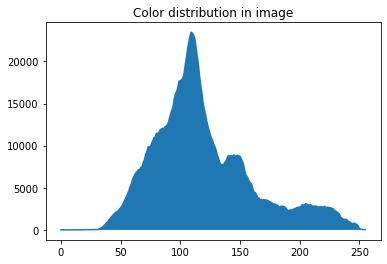

In [45]:
import matplotlib.pyplot as plt
import numpy as np

with open('hist.txt', 'r') as f:
  lines = [i.strip() for i in f.readlines()]
  stat = [int(i) for i in lines[0].split()]

plt.plot(stat)
plt.fill_between(range(256), 0, stat)
plt.title("Color distribution in image")
plt.show()

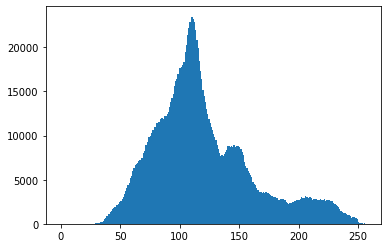

In [46]:
#check

import cv2
img = cv2.imread('medn_7.jpg',0)
plt.hist(img.ravel(), 256, [0,256])
plt.show()